In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from astropy.visualization import make_lupton_rgb

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import copy

import pickle

from collections import deque

In [3]:
# some useful functions I always end up needing

def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec


def findMoveables(world): # need to find and fix this
  for i in range(world.shape[0]):
    for j in range(world.shape[0]):
      if world[i,j,0].static == 0:
        moveList.append([i,j])
  return moveList


# pytorch softmax (need to get this below where it should be)
sm = nn.Softmax(dim=1)

In [4]:
# neural net models that be be used

class DQN(nn.Module):

    def __init__(self, numFilters):
        super(DQN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=numFilters, kernel_size=1)
        self.l2 = nn.Linear(405 + 245,350)
        self.l3 = nn.Linear(350,350)
        self.l4 = nn.Linear(350,100)
        self.l5 = nn.Linear(100,4)
        self.avg_pool = nn.MaxPool2d(3, 1, padding=0)
        self.dropout = nn.Dropout(0.1)
        self.conv_bn = nn.BatchNorm2d(5)

    def forward(self, x):
        """
        forward of DQN
        """
        x = x/255
        y1 = F.relu(self.conv_layer1(x))
        # ave pool here used to "count" the gems in areas around the agent. Might want to increase stride since should be pretty low res input
        y2 = self.avg_pool(y1)
        y2 = torch.flatten(y2,1)
        y1 = torch.flatten(y1, 1)
        y = torch.cat((y1,y2),1)
        y = F.relu(self.l2(y))
        y = F.relu(self.l3(y))
        y = F.relu(self.l4(y))
        value = self.l5(y)
        return value

In [5]:
# create the list of neural net models that can be assigned to agents. right now, just DQN is built

class modelClass:

    kind = 'model'                    # class variable shared by all instances

    def __init__(self, value, lr, replaySize):
        self.modeltype = 'double_dqn'  
        self.model1 = DQN(value)
        self.model2 = DQN(value)
        self.optimizer = torch.optim.Adam(self.model1.parameters(), lr=lr, weight_decay=0.01)
        self.loss_fn = nn.MSELoss()
        self.replay = deque([],maxlen=replaySize)

In [6]:
# define the object classes for a game

class Gem:

    kind = 'gem'                    # class variable shared by all instances

    def __init__(self, value, color):
        self.health = 1             # for the gen, whether it has been mined or not
        self.appearence = color    # gems are green
        self.vision = 1             # gems can see one radius around them
        self.policy = "NA"          # gems do not do anything
        self.value = value          # the value of this gem
        self.reward = 0             # how much reward this gem has found (will remain 0)
        self.static = 1             # whether the object gets to take actions or not
        self.passable = 1           # whether the object blocks movement
        self.trainable = 0           # whether there is a network to be optimized

class Agent:

    kind = 'agent'                  # class variable shared by all instances

    def __init__(self, model):
        self.health = 10            # for the agents, this is how hungry they are
        self.appearence = [0.,0.,255.]    # agents are blue
        self.vision = 4             # agents can see three radius around them
        self.policy = model         # agent model here. need to add a tad that tells the learning somewhere that it is DQN
        self.value = 0              # agents have no value
        self.reward = 0             # how much reward this agent has collected
        self.static = 0             # whether the object gets to take actions or not
        self.passable = 0           # whether the object blocks movement
        self.trainable = 1           # whether there is a network to be optimized

class deadAgent:

    kind = 'deadAgent'               # class variable shared by all instances

    def __init__(self):
        self.health = 10            # for the agents, this is how hungry they are
        self.appearence = [130.,130.,130.]    # agents are blue
        self.vision = 4             # agents can see three radius around them
        self.policy = "NA"         # agent model here. 
        self.value = 0              # agents have no value
        self.reward = 0             # how much reward this agent has collected
        self.static = 1             # whether the object gets to take actions or not
        self.passable = 0           # whether the object blocks movement
        self.trainable = 0           # whether there is a network to be optimized

class Wolf:

    kind = 'wolf'                  # class variable shared by all instances

    def __init__(self, model):
        self.health = 10            # for the agents, this is how hungry they are
        self.appearence = [255.,0.,0.]    # agents are red
        self.vision = 4             # agents can see three radius around them
        self.policy = model         # gems do not do anything
        self.value = 0              # agents have no value
        self.reward = 0             # how much reward this agent has collected
        self.static = 0             # whether the object gets to take actions or not
        self.passable = 0           # whether the object blocks movement
        self.trainable = 1           # whether there is a network to be optimized

class Wall:

    kind = 'wall'                  # class variable shared by all instances

    def __init__(self):
        self.health = 0            # wall stuff is basically empty
        self.appearence = [153., 51., 102.]    # walls are purple
        self.vision = 0             # wall stuff is basically empty
        self.policy = "NA"          # walls do not do anything
        self.value = 0              # wall stuff is basically empty
        self.reward = -.1             # wall stuff is basically empty
        self.static = 1             # wall stuff is basically empty
        self.passable = 0           # you can't walk through a wall
        self.trainable = 0           # whether there is a network to be optimized

class BlastRay:

    kind = 'blastray'                  # class variable shared by all instances

    def __init__(self):
        self.health = 0            
        self.appearence = [255., 255., 255.]    # blast rays are white
        self.vision = 0             # rays do not see
        self.policy = "NA"          # rays do not think
        self.value = 10              # amount of damage if you are hit by the ray
        self.reward = 0             # rays do not want
        self.static = 1             # rays exist for one turn
        self.passable = 1           # you can't walk through a ray without being blasted
        self.trainable = 0           # rays do not learn
        
        
class EmptyObject:

    kind = 'empty'                  # class variable shared by all instances

    def __init__(self):
        self.health = 0             # empty stuff is basically empty
        self.appearence = [0.,0.,0.]  #empty is well, blank 
        self.vision = 1             # empty stuff is basically empty
        self.policy = "NA"          # empty stuff is basically empty
        self.value = 0              # empty stuff is basically empty
        self.reward = 0             # empty stuff is basically empty
        self.static = 1             # whether the object gets to take actions or not
        self.passable = 1           # whether the object blocks movement
        self.trainable = 0           # whether there is a network to be optimized


In [7]:
# generate the view of an agent. 

def agentVisualField(world, location, k = 4, wall_app = [153., 51., 102.]):
  '''
  Create an agent visual field of size (2k + 1, 2k + 1) pixels
  '''

  bounds = (location[0] - k, location[0] + k, location[1] - k, location[1] + k)
  # instantiate image
  image_r = np.random.random((bounds[1] - bounds[0] + 1, bounds[3] - bounds[2] + 1))
  image_g = np.random.random((bounds[1] - bounds[0] + 1, bounds[3] - bounds[2] + 1))
  image_b = np.random.random((bounds[1] - bounds[0] + 1, bounds[3] - bounds[2] + 1))

  for i in range(bounds[0], bounds[1] + 1):
    for j in range(bounds[2], bounds[3] + 1):
      # while outside the world array index...
      if i < 0 or j < 0 or i >= world.shape[0] - 1 or j >= world.shape[1]:
        # image has shape bounds[1] - bounds[0], bounds[3] - bounds[2]
        # visual appearance = wall
        image_r[i - bounds[0], j - bounds[2]] = wall_app[0]
        image_g[i - bounds[0], j - bounds[2]] = wall_app[1]
        image_b[i - bounds[0], j - bounds[2]] = wall_app[2]
      else:
        image_r[i - bounds[0], j - bounds[2]] = world[i,j,0].appearence[0]
        image_g[i - bounds[0], j - bounds[2]] = world[i,j,0].appearence[1]
        image_b[i - bounds[0], j - bounds[2]] = world[i,j,0].appearence[2]
  
  image = make_lupton_rgb(image_r, image_g, image_b, stretch=0.5)
  return image

In [8]:
# create the empty grid world

def createWorld(height, width, layers, defaultObject):
  world = np.full((height, width, layers), defaultObject)
  return world

In [9]:
# training function. gamma and batch size should be made into inputs

def training(world, models, agentModel, batch_size, gamma):

  loss = torch.tensor(0.)
  
  if len(models[agentModel].replay) > batch_size:
    
    minibatch = random.sample(models[agentModel].replay, batch_size) 
    state1_batch = torch.cat([s1 for (s1,a,r,s2, d) in minibatch]) 
    action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
    reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
    state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
    done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])      

    Q1 = models[agentModel].model1(state1_batch.reshape(batch_size,3,9,9))
    with torch.no_grad():
      Q2 = models[agentModel].model2(state2_batch.reshape(batch_size,3,9,9))

    Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2.detach(),dim=1)[0])
    X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()

    models[agentModel].optimizer.zero_grad()
    loss = models[agentModel].loss_fn(X, Y.detach())
    loss.backward()
    models[agentModel].optimizer.step()
  return world, models, loss


In [10]:
# this is bad code below, but as a test of making a visual representation

def createWorldImage(world):
  image_r = np.random.random((world.shape[0],world.shape[0]))
  image_g = np.random.random((world.shape[0],world.shape[0]))
  image_b = np.random.random((world.shape[0],world.shape[0]))

  for i in range(world.shape[0]):
    for j in range(world.shape[0]):
      image_r[i,j] = world[i,j,0].appearence[0]
      image_g[i,j] = world[i,j,0].appearence[1]
      image_b[i,j] = world[i,j,0].appearence[2]

  image = make_lupton_rgb(image_r, image_g, image_b, stretch=0.5)
  return image

In [11]:
# generate the gem search game objects

agent1 = Agent(0)
agent2 = Agent(1)
gem1 = Gem(5, [0.,255.,0.])
gem2 = Gem(15, [255.,0.,0.])
wolf1 = Wolf(1)
emptyObject = EmptyObject()
walls = Wall()

In [12]:
# create the instances
def createGemWorldSingle(worldSize, agentp = .0, gem1p = .115, gem2p = .06):
  gems = 0
  agents = 0
  gems = 0

  # make the world and populate
  world = createWorld(worldSize,worldSize,1,emptyObject)

  for i in range(worldSize):
    for j in range(worldSize):
      obj = np.random.choice([0,1,2,3], p = [agentp, gem1p, gem2p, 1 - agentp - gem1p - gem2p])
      if obj == 0:
        world[i,j,0] = agent1
        agents =+ 1
      if obj == 1:
        world[i,j,0] = gem1
        wolves =+ 1
      if obj == 2:
        world[i,j,0] = gem2
        gems =+ 1

  cBal =  np.random.choice([0,1])
  if cBal == 0:
    world[round(worldSize/2),round(worldSize/2),0] = agent1
    world[round(worldSize/2)+1,round(worldSize/2)-1,0] = agent2
  if cBal == 1:
    world[round(worldSize/2),round(worldSize/2),0] = agent2
    world[round(worldSize/2)+1,round(worldSize/2)-1,0] = agent1

  for i in range(worldSize):
    world[0,i,0] = walls
    world[worldSize-1,i,0] = walls
    world[i,0,0] = walls
    world[i,worldSize-1,0] = walls
    
  return world


In [13]:


def createGemWorldSingleTest(worldSize, agentp = .0, gem1p = .1, gem2p = .0):
  gems = 0
  agents = 0
  gems = 0

  # make the world and populate
  world = createWorld(worldSize,worldSize,1,emptyObject)

  for i in range(worldSize):
    for j in range(worldSize):
      obj = np.random.choice([0,1,2,3], p = [agentp, gem1p, gem2p, 1 - agentp - gem1p - gem2p])
      if obj == 1:
        if i > round(worldSize/2):
            world[i,j,0] = gem1
        else:
            world[i,j,0] = gem2

    
  cBal =  np.random.choice([0,1])
  if cBal == 0:
    world[round(worldSize/2),round(worldSize/2),0] = agent1
    world[round(worldSize/2)+1,round(worldSize/2)-1,0] = agent2
  if cBal == 1:
    world[round(worldSize/2),round(worldSize/2),0] = agent2
    world[round(worldSize/2)+1,round(worldSize/2)-1,0] = agent1

  for i in range(worldSize):
    world[0,i,0] = walls
    world[worldSize-1,i,0] = walls
    world[i,0,0] = walls
    world[i,worldSize-1,0] = walls

  return world

In [14]:
# test the world models

def gameTest(worldSize):
  world = createGemWorldSingle(worldSize)
  image = createWorldImage(world)

  moveList = []
  for i in range(world.shape[0]):
    for j in range(world.shape[0]):
      if world[i,j,0].static == 0:
        moveList.append([i,j])

  img = agentVisualField(world, (moveList[0][0],moveList[0][1]), k = 4)

  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.subplot(1, 2, 2)
  plt.imshow(img)
  plt.show()


In [15]:
# ---------------------------------------------------------------------
#                      Agent transition rules (updated)
# ---------------------------------------------------------------------

def agentTransitions(holdObject, action, world, models, i, j, rewards, totalRewards, done, input, expBuff = True):

  newLoc1 = i
  newLoc2 = j

  reward = 0

  if action == 0:
    attLoc1 = i-1
    attLoc2 = j

  if action == 1:
    attLoc1 = i+1
    attLoc2 = j

  if action == 2:
    attLoc1 = i
    attLoc2 = j-1

  if action == 3:
    attLoc1 = i
    attLoc2 = j+1

  if world[attLoc1, attLoc2, 0].passable == 1:
    world[i,j,0] = EmptyObject()
    reward = world[attLoc1,attLoc2,0].value
    holdObject.reward =+ world[attLoc1,attLoc2,0].value # this may be a typo or not even needed anymore
    rewards =+ world[attLoc1,attLoc2,0].value
    world[attLoc1,attLoc2,0] = holdObject
    newLoc1 = attLoc1
    newLoc2 = attLoc2
    totalRewards = totalRewards + rewards
  else:
    if world[attLoc1,attLoc2,0].kind == "wall":
      reward = -.1
      rewards =+ -.1
      # we may also want to kill the agent if it walks into a wolf and give
      # the wolf rewards like the idea below for the dealth of agents
 
  if expBuff == True:
    img2 = agentVisualField(world, (newLoc1, newLoc2),holdObject.vision)
    input2 = torch.tensor(img2).unsqueeze(0).permute(0,3,1,2).float()
    exp = (input, action, reward, input2, done)
    models[holdObject.policy].replay.append(exp)

  return world, models, totalRewards


In [16]:

# ---------------------------------------------------------------------
#                      Wolf transition rules (updated)
# ---------------------------------------------------------------------

def wolfTransitions(holdObject, action, world, models, i, j, rewards, wolfEats, done, input, expBuff = True):

  newLoc1 = i
  newLoc2 = j

  reward = 0

  if action == 0:
    attLoc1 = i-1
    attLoc2 = j

  if action == 1:
    attLoc1 = i+1
    attLoc2 = j

  if action == 2:
    attLoc1 = i
    attLoc2 = j-1

  if action == 3:
    attLoc1 = i
    attLoc2 = j+1
    
  if world[attLoc1, attLoc2, 0].passable == 1:
    world[i,j,0] = EmptyObject()
    world[attLoc1,attLoc2,0] = holdObject
    newLoc1 = attLoc1
    newLoc2 = attLoc2
    reward = 0
  else:
    if world[attLoc1,attLoc2,0].kind == "wall":
      reward = -.1
      rewards = rewards - .1
    if world[attLoc1,attLoc2,0].kind == "agent":
      reward = 10
      rewards = rewards + 10
      wolfEats = wolfEats + 1

      if expBuff == True:

          imgDead = agentVisualField(world, (attLoc1,attLoc2), world[attLoc1,attLoc2,0].vision)
          inputDead = torch.tensor(imgDead).unsqueeze(0).permute(0,3,1,2).float()
          QDead = models[world[attLoc1,attLoc2,0].policy].model1(inputDead)
          pDead = sm(QDead).detach().numpy()[0]
          actionDead = np.random.choice([0,1,2,3], p = pDead)
                  
          imgDead2 = agentVisualField(world, (attLoc1,attLoc2,j), world[attLoc1,attLoc2,0].vision)
          inputDead2 = torch.tensor(imgDead).unsqueeze(0).permute(0,3,1,2).float()
          exp = (inputDead, actionDead, -10, inputDead2, 1)
          models[world[attLoc1,attLoc2,0].policy].replay.append(exp)

      world[attLoc1,attLoc2,0] = deadAgent()

  if expBuff == True:

    img2 = agentVisualField(world, (newLoc1, newLoc2),holdObject.vision)
    input2 = torch.tensor(img2).unsqueeze(0).permute(0,3,1,2).float()
    exp = (input, action, reward, input2, done)
    models[holdObject.policy].replay.append(exp)

  return world, models, wolfEats

In [17]:
# play and learn the game

def playGame(models, worldSize = 15, epochs = 200000, epsilon = 1):

  maxEpochs = 100
  losses = 0
  totalRewards = 0
  rewards = 0
  done = 0
  status = 1
  turn = 0
  sync_freq = 500
  game = 0
  turn = 0

  for epoch in range(epochs):
    world =createGemWorldSingle(worldSize)
    rewards = 0
    done = 0
    withinTurn = 0
    wolfEats = 0
    agentEats = 0
    while(done == 0):
      
      withinTurn = withinTurn + 1
      turn = turn+1
      
      if turn % sync_freq == 0: 
        for mods in range(len(models)):
          models[mods].model2.load_state_dict(models[mods].model1.state_dict())
      moveList = []
      for i in range(world.shape[0]):
        for j in range(world.shape[0]):
          if world[i,j,0].static == 0:
            moveList.append([i,j])
            
      # need to randomize who gets to go first. Else it is always upper left goes first. I think this will do that
      random.shuffle(moveList)

      for objs in moveList:
        i = objs[0]
        j = objs[1]
        holdObject = world[i,j,0]

        img = agentVisualField(world, (i,j), holdObject.vision)
        input = torch.tensor(img).unsqueeze(0).permute(0,3,1,2).float()
        if holdObject.static != 1:
          Q = models[holdObject.policy].model1(input)
          p = sm(Q).detach().numpy()[0]

          if epsilon > .5:
            if (random.random() < epsilon): #I
                action = np.random.randint(0,4)
            else:
                action = np.argmax(Q.detach().numpy())
          else:
            action = np.random.choice([0,1,2,3], p = p)

        if withinTurn == maxEpochs:
          done = 1

        if holdObject.kind == "agent":
          world, models, totalRewards = agentTransitions(holdObject, action, world, models, i, j, rewards, totalRewards, done, input)

        if holdObject.kind == "wolf":
          world, models, wolfEats = wolfTransitions(holdObject, action, world, models, i, j, rewards, wolfEats, done, input)

    if epsilon > 0.1:
        epsilon -= (1/(turn))

    if epsilon > 0.2: 
        if epoch > 1000 and epoch%10000 == 0:
            epsilon -= .1

    # only train at the end of the game, and train each of the models that are in the model list
    for mod in range(len(models)):
      world, models, loss = training(world, models, mod, 150, .9)
      losses = losses + loss.detach().numpy()

    if epoch % 100 == 0:
      print(epoch, totalRewards, wolfEats, losses, Q.detach().numpy(), epsilon)
      wolfEats = 0
      agentEats = 0
      losses = 0
      totalRewards = 0
  return models


In [18]:
# below needs to be edits, but the agent and wolf transitions functions needs to be modified first to have an update or not flag so that tha watching isn't 
# changing the models and adding to the replay buffers. this should just be watching

def watchAgame(world, models, epochs, maxEpochs):
  fig = plt.figure()
  ims = []

  epochs = 1
  losses = 0
  totalRewards = 0
  rewards = 0
  done = 0
  status = 1
  turn = 0
  game = 0
  turn = 0

  for epoch in range(epochs):
    
    rewards = 0
    done = 0
    withinTurn = 0
    wolfEats = 0
    while(done == 0):
        
      image = createWorldImage(world)
      im = plt.imshow(image, animated=True)
      ims.append([im])
    
      withinTurn = withinTurn + 1
      turn = turn+1
          
      moveList = []
      for i in range(world.shape[0]):
        for j in range(world.shape[0]):
          if world[i,j,0].static == 0:
            moveList.append([i,j])

      # need to randomize who gets to go first. Else it is always upper left goes first. I think this will do that
      random.shuffle(moveList)

      for objs in moveList:
        i = objs[0]
        j = objs[1]
        holdObject = world[i,j,0]

        # replace the below with the object instance knowing where it is. Below is a hack that I realized when moving to new vision function
        newLoc1 = i
        newLoc2 = j

        img = agentVisualField(world, (i,j), holdObject.vision)
        input = torch.tensor(img).unsqueeze(0).permute(0,3,1,2).float()
        if holdObject.static != 1:

          Q = models[holdObject.policy].model1(input)
          p = sm(Q).detach().numpy()[0]

          action = np.random.choice([0,1,2,3], p = p)

        if holdObject.kind == "agent":
          world, models, totalRewards = agentTransitions(holdObject, action, world, models, i, j, rewards, totalRewards, done, input)

        if holdObject.kind == "wolf":
          world, models, wolfEats = wolfTransitions(holdObject, action, world, models, i, j, rewards, wolfEats, done, input)

        if withinTurn == maxEpochs:
          done = 1
  ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
  plt.show()
  return ani


In [19]:
# view a replay memory

def examineReplay(models, index, modelnum):

  #input, action, reward, input2, done

  image_r =  models[modelnum].replay[index][0][0][0].numpy()
  image_g =  models[modelnum].replay[index][0][0][1].numpy()
  image_b =  models[modelnum].replay[index][0][0][2].numpy()

  image = make_lupton_rgb(image_r, image_g, image_b, stretch=0.5)

  image_r =  models[modelnum].replay[index][3][0][0].numpy()
  image_g =  models[modelnum].replay[index][3][0][1].numpy()
  image_b =  models[modelnum].replay[index][3][0][2].numpy()

  image2 = make_lupton_rgb(image_r, image_g, image_b, stretch=0.5)  

  action = models[modelnum].replay[index][1]
  reward = models[modelnum].replay[index][2]
  done = models[modelnum].replay[index][4]

  return image, image2, (action, reward, done)

In [20]:
# look at a few replay games

def replayGames(numGames, modelNum, startingMem):
  for i in range(numGames):
    image, image2, memInfo = examineReplay(models, i+startingMem,modelNum)

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="Blues_r")
    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap="Accent_r")

    print(memInfo)

    plt.show()

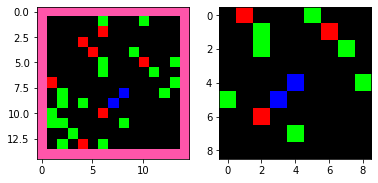

In [21]:
# check visual layout

gameTest(15)

In [ ]:
# setup a game and save models (this is a quick proof of principle version that can be vastly improved on)
# note, the outputs can be better done than the hard coded print, but we need something. So much debugging
# happened watching things like Q values and gains when running that I was able to fix immediately

newModels = 2

# create neuralnet models
if newModels == 1:
    models = []
    models.append(modelClass(5,.0001, 1500)) # agent1 model
    models.append(modelClass(5,.0001, 1500)) # agent2 model
    models = playGame(models, 15, 10000, .85)
    with open("modelFile, "wb") as fp: 
        pickle.dump(models, fp)
    
if newModels == 2:
    with open("modelFile", "rb") as fp:  
        models = pickle.load(fp)

for games in range(10): 
    models = playGame(models, 15, 50000, .3)
    with open("modelFile_"+str(games), "wb") as fp: 
        pickle.dump(models, fp)

0 135 0 14.196507453918457 [[27.406546 26.426352 31.274462 23.355646]] 0.84
100 16500 0 1560.9036228656769 [[12.578524 12.206776 12.159488 12.240932]] 0.7980272149226139
200 16070 0 1465.9320299625397 [[6.921689  7.1191907 7.0397253 7.060891 ]] 0.7911699392750043
300 17060 0 1477.731056213379 [[10.178653  8.959972  9.8611    9.381487]] 0.7871401386056421
400 17330 0 1558.184595823288 [[13.930838 13.496749 12.375318 15.075505]] 0.7842757654323739
0 170 0 11.640006065368652 [[8.045526 9.180646 7.843486 9.472687]] 0.29
100 22365 0 733.9409265518188 [[3.6465874 3.0543036 3.419299  3.2177773]] 0.2480272149226137
200 23725 0 686.6989550590515 [[3.0577815 3.790864  3.087444  3.7304478]] 0.24116993927500424
300 24915 0 725.3134090900421 [[3.359049  3.8665543 3.7245243 3.4541612]] 0.23714013860564265
400 23100 0 647.0242096185684 [[29.738373 44.318893 38.074757 34.877407]] 0.23427576543237447
500 23615 0 685.1253001689911 [[7.4033566 7.3687267 6.565415  8.228249 ]] 0.2320518056202543
600 23945 

8300 23775 0 719.9040107727051 [[3.3799515 3.2327445 3.2427225 3.4308338]] 0.20398592834145854
8400 23600 0 748.9546172618866 [[2.8886416 3.0647466 3.0328124 2.9541829]] 0.20386618794190006
8500 23205 0 670.3583438396454 [[2.6774244 2.8593776 2.5266194 2.9936564]] 0.2037478643702428
8600 23895 0 696.8499108552933 [[3.9252841 2.9801335 3.7478304 3.1345654]] 0.20363092448898065
8700 23895 0 688.1623252630234 [[3.284804  3.7345116 3.6590624 3.4322202]] 0.20351533630973806
8800 24560 0 705.7847644090652 [[2.94795   2.8458626 3.0559726 2.7416966]] 0.20340106894074444
8900 24335 0 714.2435508966446 [[2.8493693 2.7888405 2.961978  2.6756928]] 0.20328809253727567
9000 23555 0 685.9794496297836 [[2.231326  2.3654563 2.2544098 2.298465 ]] 0.2031763782548643
9100 23700 0 661.4766004085541 [[3.0519705 2.4772332 3.1813912 2.3950317]] 0.20306589820509396
9200 23650 0 681.4679296016693 [[2.8485086 2.962023  2.7572887 3.1314497]] 0.20295662541380988
9300 25005 0 765.1232365369797 [[1.6515771 2.5064332

16900 24085 0 748.716017127037 [[2.4523177 2.3882117 2.4676528 2.3682766]] 0.09999956991724093
17000 23805 0 669.5210880041122 [[3.0761213 3.2015166 3.5841827 2.835285 ]] 0.09999956991724093
17100 24010 0 632.5328608751297 [[2.487057  2.3851833 2.7612143 2.0763025]] 0.09999956991724093
17200 23385 0 671.9766643047333 [[2.0936642 2.5925403 2.211448  2.4447603]] 0.09999956991724093
17300 24630 0 716.5247452259064 [[2.469833  3.0526352 2.6062083 2.834807 ]] 0.09999956991724093
17400 24035 0 676.8345713615417 [[3.2346354 3.1790538 3.4783306 2.9714396]] 0.09999956991724093
17500 23870 0 666.9756227731705 [[2.6362357 2.8315525 2.5662699 2.8754523]] 0.09999956991724093
17600 23740 0 696.8595896959305 [[2.9917066 4.8928123 4.059392  3.8720798]] 0.09999956991724093
17700 23245 0 627.0130470991135 [[2.131426  2.0620997 2.2220097 1.9369885]] 0.09999956991724093
17800 23620 0 636.2406712770462 [[2.500947  2.3214486 2.4975138 2.3537722]] 0.09999956991724093
17900 23765 0 695.7781014442444 [[3.78605

25500 23900 0 647.6008404493332 [[2.828126  3.2245283 3.0000553 2.9481268]] 0.09999956991724093
25600 24090 0 691.0148824453354 [[2.499287  2.6620786 2.5885735 2.5467105]] 0.09999956991724093
25700 24185 0 671.4653205871582 [[7.7923713 8.300317  7.7445335 8.181468 ]] 0.09999956991724093
25800 24580 0 701.610313296318 [[3.1414416 3.245682  3.2505057 3.0259206]] 0.09999956991724093
25900 23830 0 678.0054334402084 [[2.4057496 2.2122934 2.302966  2.394049 ]] 0.09999956991724093
26000 23495 0 705.5248719453812 [[2.1992052 2.511798  2.4649155 2.2317886]] 0.09999956991724093
26100 23885 0 674.3644286394119 [[6.0250793 6.318656  5.565341  7.0094914]] 0.09999956991724093
26200 24220 0 643.6054350137711 [[3.1214957 2.9599655 2.9323893 3.1355042]] 0.09999956991724093
26300 23675 0 610.5367690324783 [[5.619702  5.5049434 5.0950627 6.1033607]] 0.09999956991724093
26400 23520 0 669.2237794399261 [[9.726048 8.426839 9.512391 8.525848]] 0.09999956991724093
26500 23585 0 619.1626623868942 [[2.3311465 2

34100 24060 0 743.8036803007126 [[3.4049108 2.756805  3.0855818 2.9673965]] 0.09999956991724093
34200 23420 0 653.2880606651306 [[2.2975214 1.8355646 1.8016766 2.2799811]] 0.09999956991724093
34300 24275 0 748.2744748592377 [[2.9749036 2.9424522 3.3952572 2.5918937]] 0.09999956991724093
34400 23050 0 652.5984193086624 [[6.0110064 3.8928182 4.535812  5.11634  ]] 0.09999956991724093
34500 24355 0 666.7212570905685 [[1.9413298 1.9363115 1.7783452 2.0272055]] 0.09999956991724093
34600 22965 0 703.9630753993988 [[5.95026   5.097931  5.1250963 6.029585 ]] 0.09999956991724093
34700 24540 0 685.2880859375 [[2.1514654 1.603192  1.7115781 2.039622 ]] 0.09999956991724093
34800 23585 0 700.3131506443024 [[1.9772329 2.2264562 1.8757657 2.3417714]] 0.09999956991724093
34900 23850 0 676.0507915019989 [[2.1639142 1.9151093 2.5130584 1.4912666]] 0.09999956991724093
35000 24010 0 656.9888459444046 [[2.0843606 2.6136842 2.2370648 2.4707806]] 0.09999956991724093
35100 23760 0 709.5350831747055 [[2.3347955

42700 23885 0 688.7041110992432 [[7.4876966 8.875605  7.934877  8.384475 ]] 0.09999956991724093
42800 23835 0 668.2882949113846 [[6.416894  6.0003476 5.3647914 7.5770316]] 0.09999956991724093
42900 23420 0 669.4885332584381 [[5.6473    5.7819486 4.8488555 7.2532225]] 0.09999956991724093
43000 23660 0 693.9558868408203 [[2.0566916 2.2934523 2.2263024 2.020329 ]] 0.09999956991724093
43100 24125 0 765.9066255092621 [[3.1922944 2.7000856 2.9254806 2.9145842]] 0.09999956991724093
43200 22950 0 669.0600615739822 [[5.6471405 5.75084   5.6814933 5.7238626]] 0.09999956991724093
43300 24685 0 735.6075010299683 [[2.3574736 2.3367994 2.2487955 2.3486998]] 0.09999956991724093
43400 24270 0 714.9483250379562 [[2.3559284 2.3568733 2.490317  2.14909  ]] 0.09999956991724093
43500 24540 0 700.1403266191483 [[2.721905  2.2652724 2.5647247 2.4106777]] 0.09999956991724093
43600 23615 0 716.6056512594223 [[2.4015596 2.2396677 2.4138203 2.1928575]] 0.09999956991724093
43700 23625 0 728.2551724910736 [[2.8152

In [ ]:
# watch game 
# (these are not ideal videos and need to be updated. Not sure why the files are movies in) jupyper but not as files)

world =createGemWorldSingle(30)
ani1 = watchAgame(world, models, 1, 100)
ani1.save('animation.gif', writer='PillowWriter', fps=2)


world =createGemWorldSingleTest(30)
ani2 = watchAgame(world, models, 1, 100)
ani2.save('animation2.gif', writer='PillowWriter', fps=2)

In [ ]:
# examine replay

replayGames(1, 0, 0)